In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

## Create dataset for regression

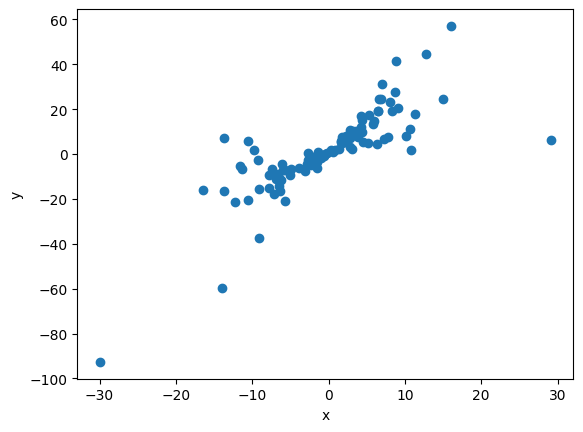

In [131]:
x = torch.randn(100, 1) * 10
y = 2*x + 1 + x * torch.randn(100, 1)

plt.plot(x.numpy(), y.numpy(), 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Test basic model

In [134]:
class CompressedModel(nn.Module):
    def __init__(self, a_init, a_index, tau=1):
        super().__init__()
        self.a = nn.Parameter(a_init)
        self.a_index = a_index
        self.tau = tau
    
    def forward(self, x):
        ## x shape [B, n]
        y = nn.Sigmoid()((x[:,self.a_index]-self.a) / self.tau)
        return y

In [135]:
a_init = torch.tensor([-15.,-5.,5.,15.], requires_grad=True)
a_index = torch.tensor([0,0,0,0])

model = CompressedModel(a_init, a_index)
output = model(x.view(-1,1))

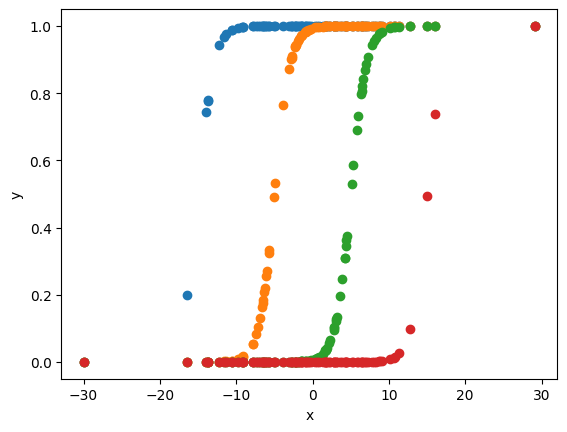

In [136]:
plt.figure()

for f in range(4):
    plt.plot(x.numpy(), output[:,f].detach().numpy(), 'o')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [137]:
model.tau = model.tau / 10
output = model(x.view(-1,1))

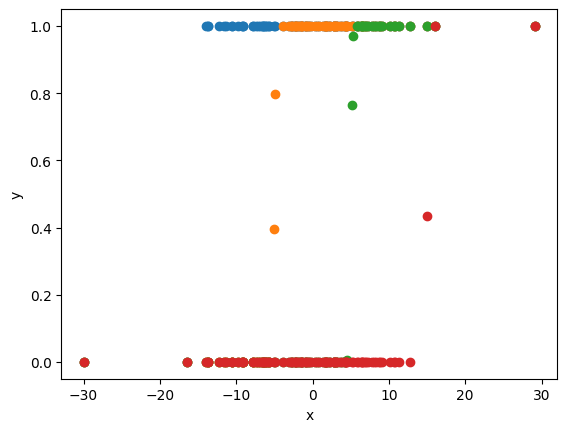

In [138]:
plt.figure()

for f in range(4):
    plt.plot(x.numpy(), output[:,f].detach().numpy(), 'o')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Create basic model + MLP

In [139]:
class CombinedModel(nn.Module):
    def __init__(self, compressed_model, linear_model):
        super().__init__()
        self.compressed_model = compressed_model
        self.linear_model = linear_model
    
    def forward(self, x, eval = False):
        ## x shape [B, n]
        y = self.compressed_model(x)
        if eval:
            y = torch.round(y)
        z = self.linear_model(y)
        return y, z

In [140]:
class MLP_small(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_features: int, num_layers: int, activation = nn.ReLU) -> None:
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            activation(),
            *[nn.Sequential(
                nn.Linear(hidden_features, hidden_features),
                activation(),
            ) for _ in range(num_layers - 2)],
            nn.Linear(hidden_features, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)    

In [141]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 4,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 2)

In [142]:
combined_model = CombinedModel(compressed_model, linear_model)
hidden_state, output = combined_model(x.view(-1,1))

In [143]:
print(output.shape)

torch.Size([100, 1])


## Train combined model

In [144]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    hidden_state, output = combined_model(x.view(-1,1))
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

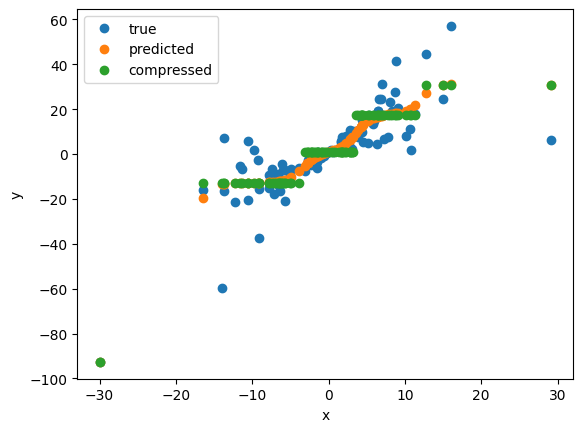

In [145]:
hidden_state, output = combined_model(x.view(-1,1))
hidden_state_compressed, output_compressed = combined_model(x.view(-1,1), eval=True)

plt.figure()
plt.plot(x.numpy(), y.numpy(), 'o', label='true')
plt.plot(x.numpy(), output.detach().numpy(), 'o', label='predicted')
plt.plot(x.numpy(), output_compressed.detach().numpy(), 'o', label='compressed')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Test on California Housing Dataset

In [200]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for regression
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [201]:
device = 'cuda'

In [254]:
linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
linear_comparison_model.to(device);

In [255]:
a_index = torch.repeat_interleave(torch.arange(8), 8)
quantiles_tensor = torch.tensor([(f+1)*11/100 for f in range(8)])
a_init = torch.quantile(X_train_tensor, quantiles_tensor, dim = 0).T.flatten()

In [256]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [257]:
def eval_val(model, val_dataloader, eval= False, device = 'cuda'):
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            if eval:
                hidden_state, output = model(x, eval=True)    
            else:    
                output = model(x) 
                if isinstance(output, tuple):
                    output = output[1]
            loss = criterion(output, y)
            losses.append(loss.item())
        return np.mean(losses)

In [268]:
def train_comparison(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print = True):
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        val_loss = eval_val(model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss        

In [283]:
def train_combined(combined_model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print=True):
    factor = 0.001 ** (1/num_epochs)
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            hidden_state, output = combined_model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        combined_model.compressed_model.tau = max(combined_model.compressed_model.tau * factor, 0.001)    
        val_loss = eval_val(combined_model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss     

In [264]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
n_epochs = 20
train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs)

Epoch 1/20, Loss: 0.2788957755348479, Val Loss: 0.3159875422716141
Epoch 3/20, Loss: 0.26858366534922473, Val Loss: 0.2795308638077516
Epoch 5/20, Loss: 0.26598415289853894, Val Loss: 0.27531933096738964
Epoch 7/20, Loss: 0.26531277423681215, Val Loss: 0.29494509169688593
Epoch 9/20, Loss: 0.26016084823844043, Val Loss: 0.26896901038976817
Epoch 11/20, Loss: 0.2605791431238023, Val Loss: 0.2923816937666673
Epoch 13/20, Loss: 0.25802622256121893, Val Loss: 0.2815695414176354
Epoch 15/20, Loss: 0.2532277986869331, Val Loss: 0.26926843432279735
Epoch 17/20, Loss: 0.2571140538410161, Val Loss: 0.2665030619272819
Epoch 19/20, Loss: 0.2498969393529633, Val Loss: 0.2848014486523775


In [267]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
n_epochs = 20
train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs)

Epoch 1/20, Loss: 0.2936740146242371, Val Loss: 0.302471452492934
Epoch 3/20, Loss: 0.2866715330832688, Val Loss: 0.2989950104401662
Epoch 5/20, Loss: 0.2859275176716867, Val Loss: 0.29899636690433207
Epoch 7/20, Loss: 0.2805502226994943, Val Loss: 0.3023467350464601
Epoch 9/20, Loss: 0.28143501610949984, Val Loss: 0.3061681341666442
Epoch 11/20, Loss: 0.2826865784130817, Val Loss: 0.3025267190658129
Epoch 13/20, Loss: 0.28345958146360495, Val Loss: 0.29552588898401994
Epoch 15/20, Loss: 0.282089119589375, Val Loss: 0.2862980170891835
Epoch 17/20, Loss: 0.28241403216077376, Val Loss: 0.29822906186947457
Epoch 19/20, Loss: 0.27591949106417885, Val Loss: 0.29866979718208314


0.28915240283195787

In [260]:
eval_val(linear_comparison_model, test_loader), eval_val(combined_model, test_loader), eval_val(combined_model, test_loader, eval=True)

(0.2805197683664469, 0.31846185968472407, 0.3205512101833637)

In [261]:
def eval_compression(model, val_dataloader, device = 'cuda'):
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            hidden_state, output = model(x)   
            hidden_state_compressed = torch.round(hidden_state) 
            loss = torch.mean(torch.abs(hidden_state - hidden_state_compressed))
            losses.append(loss.item())
        return np.mean(losses)

In [262]:
eval_compression(combined_model, test_loader)

0.0010636050164556275

## Evaluate multiple trainings

In [ ]:
val_losses_comparison = []
for f in tqdm(range(15)):
    linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
    linear_comparison_model.to(device);
    n_epochs=30
    optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs, print=False)
    val_losses_comparison.append(val_loss_current)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
val_losses_combined = []
val_losses_compressed = []
for f in tqdm(range(15)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = 64,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    n_epochs=30
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, print=False)
    val_losses_combined.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval = True)
    val_losses_compressed.append(val_loss_current)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


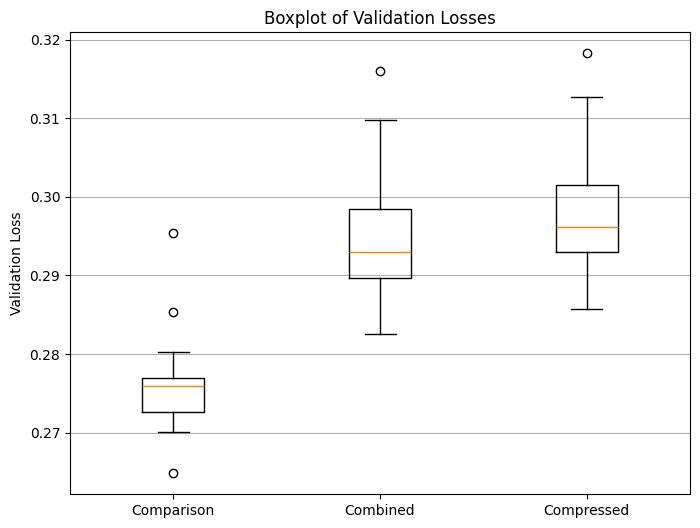

In [287]:
plt.figure(figsize=(8, 6))
plt.boxplot([val_losses_comparison, val_losses_combined, val_losses_compressed], labels=['Comparison', 'Combined', 'Compressed'])
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()

## Comparison Trees

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=256, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")


Random Forest MSE: 0.2943514717259703


In [194]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=64, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 0.6030945966593108


In [198]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")

Decision Tree MSE: 0.4972838079675652


## Include extra loss (does not work)

In [74]:
class extra_loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, hidden_state, output, target):
        mse = torch.mean((output - target)**2)
        compress_loss = torch.mean(torch.sqrt(hidden_state * (1- hidden_state)))
        return mse + 0*compress_loss

In [75]:
x.shape

torch.Size([64, 8])

In [184]:
compressed_model_new = CompressedModel(a_init, a_index)
linear_model_new = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 3)
combined_model_new = CombinedModel(compressed_model_new, linear_model_new)
combined_model_new.to(device);

In [185]:
loss_fn = extra_loss()
x,y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)
hidden_state, output  = combined_model_new(x)
loss_fn(hidden_state, output, y)

tensor(4.1582, device='cuda:0', grad_fn=<AddBackward0>)

In [186]:
mse = torch.mean((output - y)**2)
compress_loss = torch.mean(torch.sqrt(hidden_state * (1- hidden_state)))
alt = torch.mean(torch.abs(hidden_state - torch.round(hidden_state)))
mse, compress_loss, alt 

(tensor(4.1582, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4554, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3562, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.0001)
n_epochs = 100
device= 'cuda'
combined_model.to(device);

for epoch in range(n_epochs):
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        hidden_state, output = combined_model_new(x)
        loss = loss_fn(hidden_state, output, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # combined_model.compressed_model.tau = combined_model.compressed_model.tau* 0.95    
    if epoch % (n_epochs//10) == 0:
        print(f'{epoch}: {np.mean(losses)}')

nan


NameError: name 'stop' is not defined

In [122]:
losses

[6.003827095031738,
 7.416029930114746,
 6.407652854919434,
 5.651641368865967,
 6.146584510803223,
 7.452125549316406,
 6.846325397491455,
 6.6485915184021,
 5.710282802581787,
 6.7766265869140625,
 4.876708507537842,
 5.792977333068848,
 6.231287479400635,
 5.990212917327881,
 8.082433700561523,
 6.944037914276123,
 6.133600234985352,
 5.246346950531006]

In [115]:
combined_model.compressed_model.a

Parameter containing:
tensor([-1.0064e+00, -7.5324e-01, -5.2322e-01, -3.1480e-01, -7.8364e-02,
         1.8183e-01,  5.4602e-01,  1.0762e+00, -1.2385e+00, -9.2114e-01,
        -5.2438e-01, -2.0697e-01,  1.8979e-01,  5.0719e-01,  7.4525e-01,
         1.3007e+00, -6.6204e-01, -4.5655e-01, -2.9990e-01, -1.5483e-01,
        -2.1204e-02,  1.2499e-01,  2.9530e-01,  5.5714e-01, -2.9180e-01,
        -2.2319e-01, -1.7488e-01, -1.3263e-01, -9.0458e-02, -4.1485e-02,
         2.2439e-02,  1.4011e-01, -7.8314e-01, -5.9933e-01, -4.5949e-01,
        -3.1350e-01, -1.4903e-01,  5.0612e-02,  3.2455e-01,  8.2252e-01,
        -8.5748e-02, -6.2216e-02, -4.6398e-02, -3.2000e-02, -1.7446e-02,
        -6.6691e-04,  2.0280e-02,  5.5974e-02, -9.1882e-01, -8.2053e-01,
        -7.5501e-01, -6.9884e-01, -1.7465e-01,  7.8482e-01,  9.9076e-01,
         1.2388e+00, -1.3401e+00, -1.1656e+00, -8.2654e-01,  8.0919e-02,
         5.9947e-01,  6.8922e-01,  8.0888e-01,  1.1230e+00], device='cuda:0',
       requires_grad=Tru

In [108]:
hidden_state[0,16:24]

tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [87]:
[torch.min(params) for params in combined_model.linear_model.parameters()]

[tensor(-0.1333, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1141, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.3130, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2942, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2756, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.2062, device='cuda:0', grad_fn=<MinBackward1>)]

In [79]:
combined_model.linear_model(hidden_state)

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward